In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from imblearn.over_sampling import SMOTE # Handling Imbalanced

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Tweet dataset
df = pd.read_csv('/content/sample_data/Tweets.csv')
df = df.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df['category'] = df['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df = df[['category','clean_text']]
# Output first five rows
df.head()

,category,clean_text
0,0.0,@VirginAmerica What @dhepburn said.
1,1.0,@VirginAmerica plus you've added commercials t...
2,0.0,@VirginAmerica I didn't today... Must mean I n...
3,-1.0,@VirginAmerica it's really aggressive to blast...
4,-1.0,@VirginAmerica and it's a really big bad thing...


In [4]:
# Separate the DataFrame into three separate DataFrames based on category
neg_df = df[df['category'] == -1.0]
neutral_df = df[df['category'] == 0.0]
pos_df = df[df['category'] == 1.0]

# Find the minimum count among all categories
min_count = min(len(neg_df), len(neutral_df), len(pos_df))

# Sample from each category to match the minimum count
resampled_neg_df = neg_df.sample(n=min_count, replace=True)
resampled_neutral_df = neutral_df.sample(n=min_count, replace=True)
resampled_pos_df = pos_df.sample(n=min_count, replace=True)

# Concatenate the resampled DataFrames
balanced_df = pd.concat([resampled_neg_df, resampled_neutral_df, resampled_pos_df])

# Shuffle the rows of the balanced DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)


balanced_df['category'].value_counts()

df = balanced_df

In [5]:
df['category'].value_counts()

category
 1.0    2363
 0.0    2363
-1.0    2363
Name: count, dtype: int64

In [6]:
# drop missing rows
df.dropna(axis=0, inplace=True)

### **EDA Analysis**

In [7]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

In [8]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

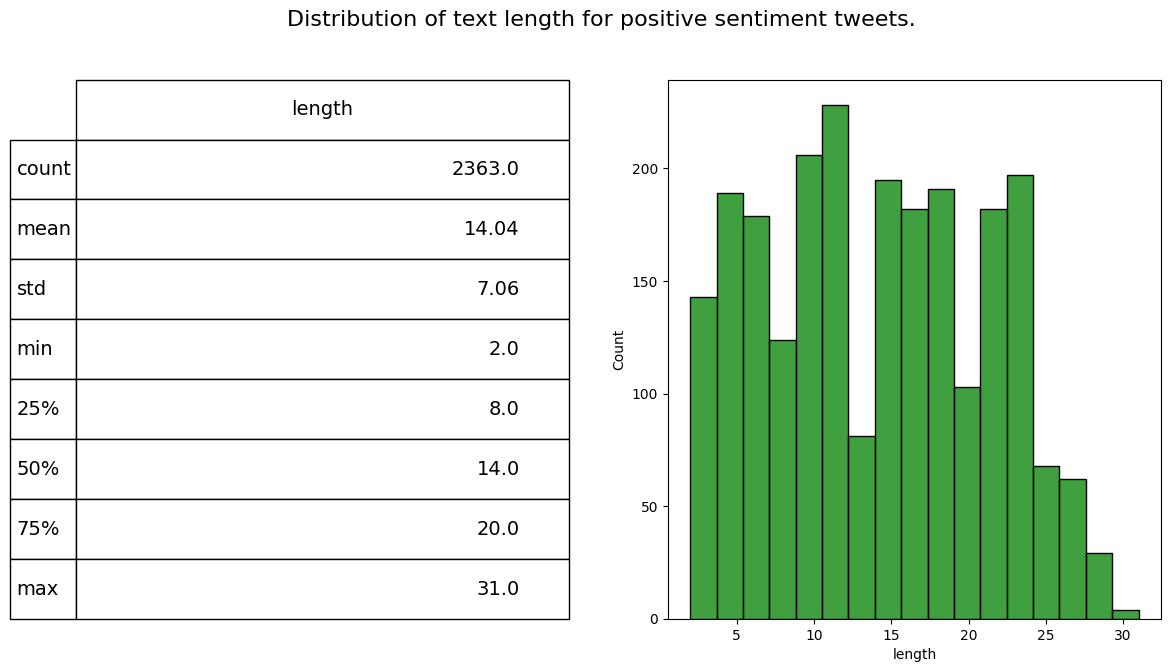

In [9]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']==1]['length'], ax=ax1,color='green')
describe = df.length[df.category==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

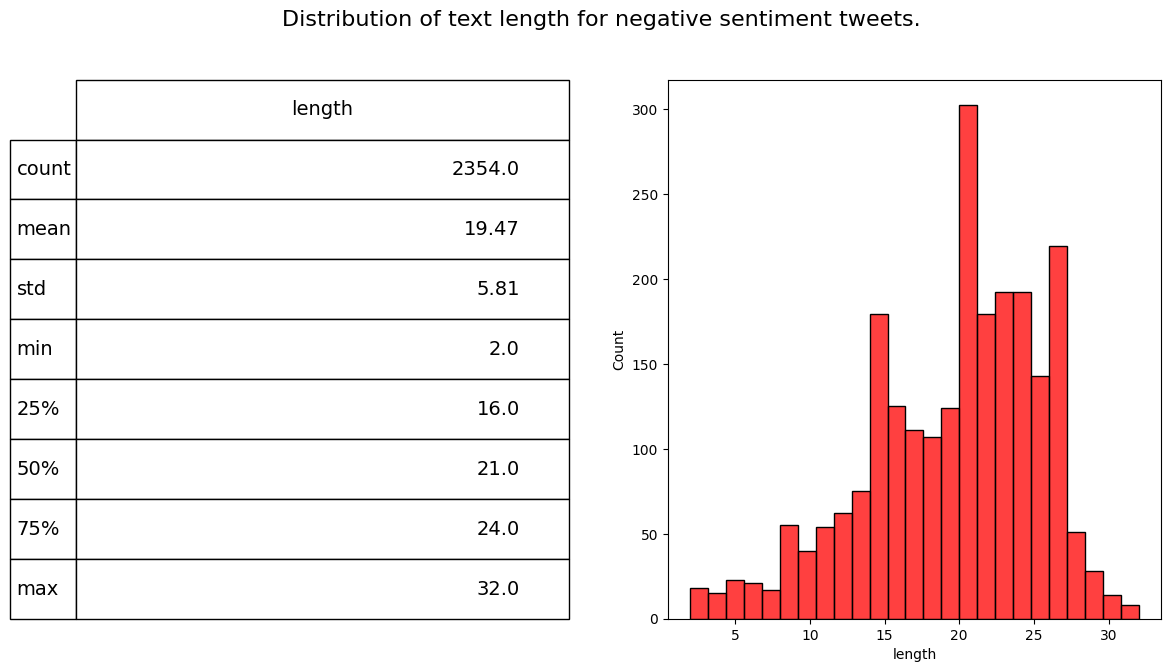

In [10]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']==-1]['length'], ax=ax1,color='red')
describe = df.length[df.category==-1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

In [11]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [12]:
df.drop(['length'], axis=1, inplace=True)

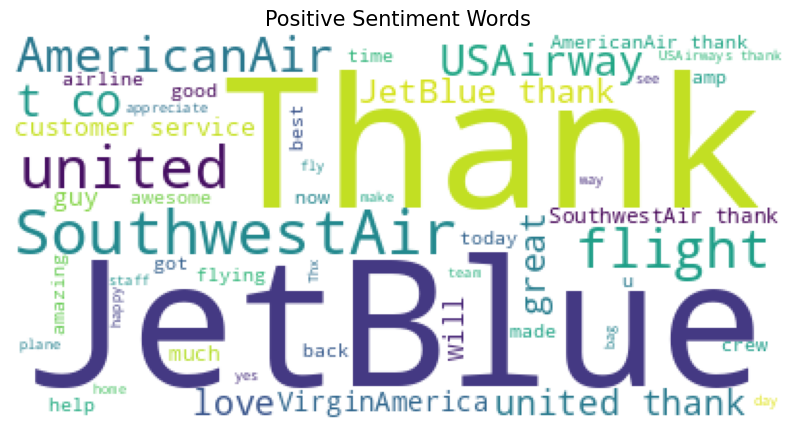

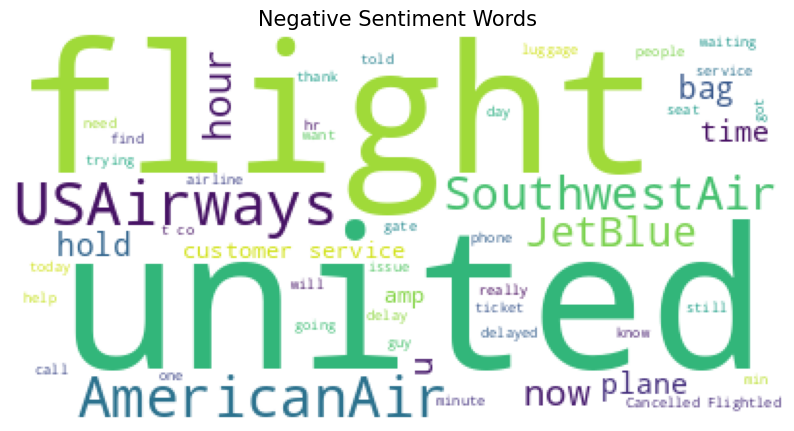

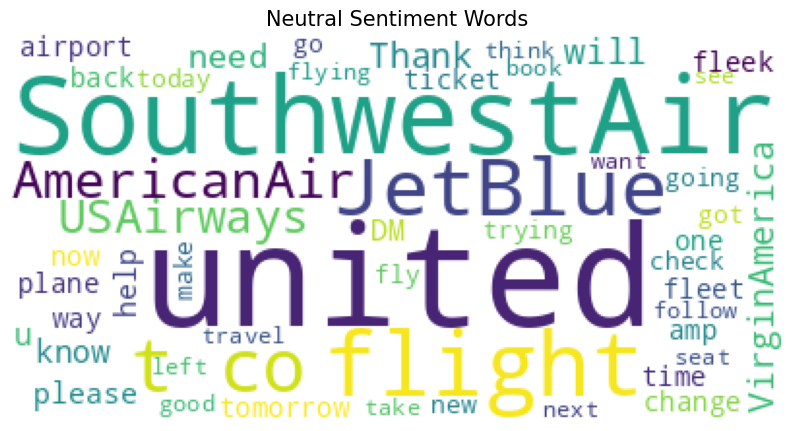

In [13]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    if category == 1:
        title = 'Positive'
    elif category == -1:
        title = 'Negative'
    else:
        title = 'Neutral'
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(title), fontsize=15)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 1)   ### Positive Tweets

# Negative tweet words
wordcount_gen(df, -1)   ### Negative Tweets

# Neutral tweet words
wordcount_gen(df, 0)    ### Neutral Tweets

## **Data Preprocessing**

In [14]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> @JetBlue Happy Anniversary!! It's hard to believe you're 15!! You're so young!

Processed tweet -> ['jetblu', 'happi', 'anniversari', 'hard', 'believ', '15', 'young']


In [15]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))
y = pd.get_dummies(df['category'])

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 @JetBlue Happy Anniversary!! It's hard to believe you're 15!! You're so young!
After Tokenization & Padding 
 [  12  265 2047   76  592    1  628  261  353  261   39 2048    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (4814, 50) (4814, 3)
Validation Set -> (1204, 50) (1204, 3)
Test Set -> (1062, 50) (1062, 3)


In [18]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## **Bidirectional LSTM Using NN**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout,SpatialDropout1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=40
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(input_dim= vocab_size, output_dim= embedding_size,input_shape= (max_len,)))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

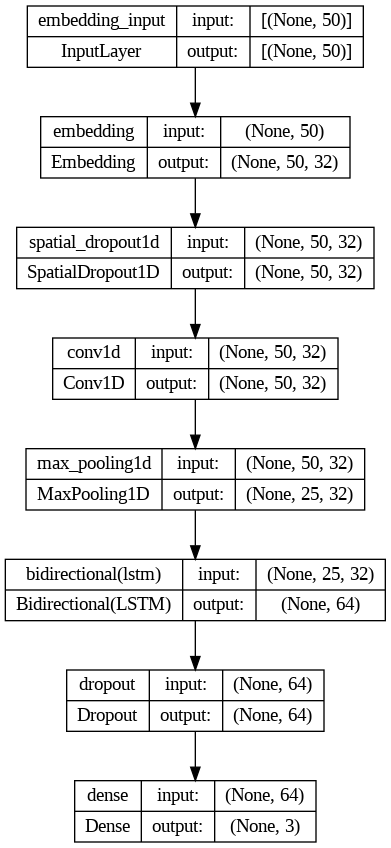

In [20]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

from keras.callbacks import LambdaCallback

batch_size = 32
epoch_list = []
loss_list = []
# Define a function to print loss after every epoch
def print_loss(epoch, logs):
    print(f'Epoch {epoch+1}/{epochs}, Loss: {logs["loss"]}')
    epoch_list.append(epoch + 1)  # Epochs start from 1
    loss_list.append(logs["loss"])
# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[LambdaCallback(on_epoch_end=print_loss)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 32)            0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                        

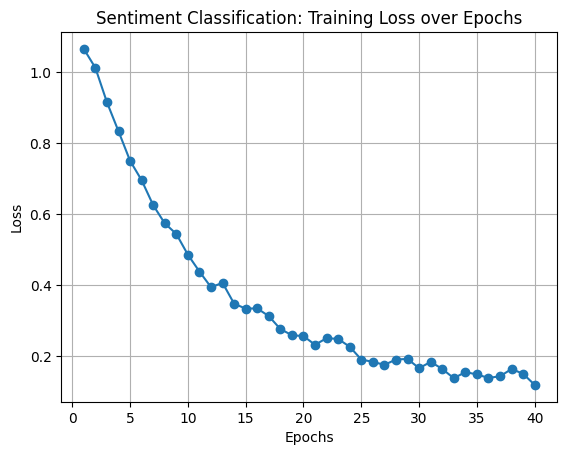

In [23]:
plt.plot(epoch_list, loss_list, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Sentiment Classification: Training Loss over Epochs')
plt.grid(True)
plt.show()

## **Model Accuracy & Loss**

In [24]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7750
Precision : 0.7751
Recall    : 0.7693
F1 Score  : 0.7722


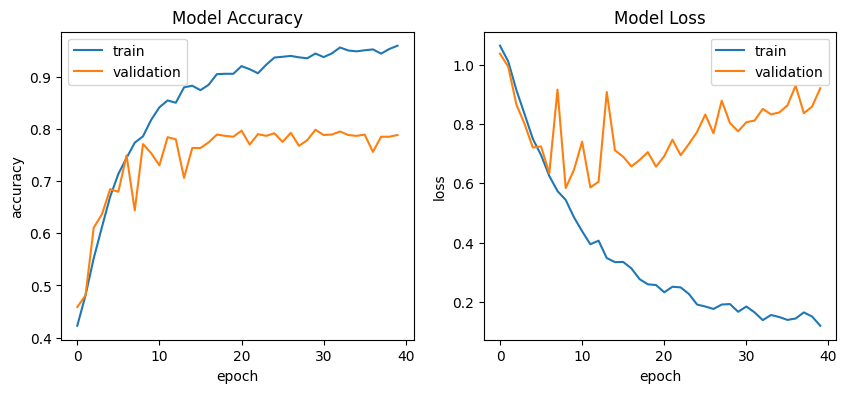

In [25]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

## **Model Confusion Matrix**

34/34 [==============================] - 1s 7ms/step


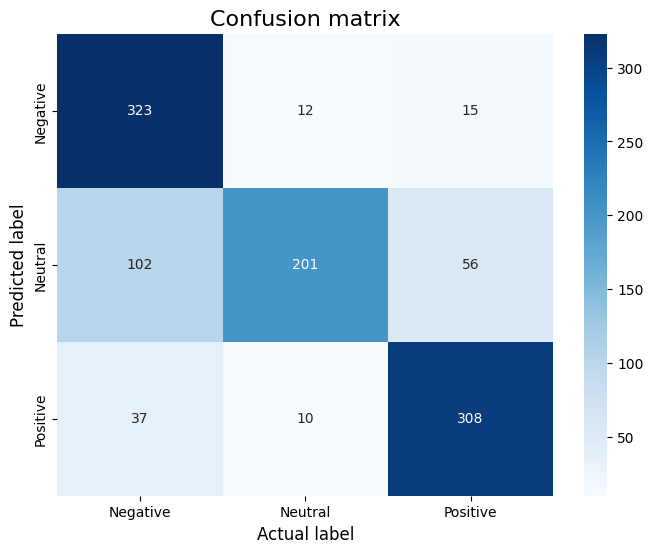

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [ ]:
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
import pickle

#saving model
model.save("/content/drive/My Drive/QuerySupport/sentimentClassificationModel.h5")

# saving tokenizer
with open('/content/drive/My Drive/QuerySupport/tokenizerSentimentClassification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 [==============================] - 0s 27ms/step
The predicted sentiment is Negative


In [ ]:
predict_class(['The food was bad'])

1/1 [==============================] - 0s 133ms/step
The predicted sentiment is Positive


In [ ]:
s = """
@VirginAmerica on iPad and iPhone, clicking the CHECKIN link in the email I received at 24hrs before flight
"""

predict_class([s])

1/1 [==============================] - 0s 79ms/step
The predicted sentiment is Neutral
